In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(16)

# Elementary SLAE

In [2]:
shape = (100, 4)
X = np.random.uniform(-20, 20, shape)
v = np.array([[1, -2, 4, 1]])
Y = np.dot(X, v.T)

noise = np.random.normal(0, 1, (shape[0], 1))
Y += noise

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [5]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [6]:
lin_reg.coef_

array([[ 1.00115878, -2.00786818,  4.01880084,  1.01116723]])

In [7]:
Y_pred = lin_reg.predict(X_test)
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))

Mean squared error: 1.22


# Custom Regressor

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_absolute_error

In [206]:
class MaeLinearRegression(BaseEstimator, RegressorMixin):   
    def __init__(self, lr, delta, n_iters):
        self.lr = lr
        self.delta = delta
        self.n_iters = n_iters
    
    def fit(self, x, y):
        w = np.zeros((1, x.shape[1])) + 1
        for i in range(self.n_iters):
            grad_Q = x.T.dot(np.sign(x.dot(w.T) - y))
            w = w - self.lr * grad_Q.T
            if mean_absolute_error(y, x.dot(w.T)) < self.delta:
                print('Exit with low error')
                break
        else:
            print('Exit with reaching n_iters')
            
        self.coef_ = w
        return self
    
    def predict(self, x):
        return x.dot(self.coef_.T)
        

In [31]:
mae = MaeLinearRegression(1e-4, 1, 10000)
mae.fit(X_train, Y_train)
mae.coef_

Exit with low error


array([[ 0.96759204, -1.99984704,  3.98369993,  0.9888786 ]])

In [34]:
y_pred = mae.predict(X_test)
print('Mean abs error: %.2f'
      % mean_absolute_error(Y_test, y_pred))

Mean abs error: 0.88


# Learn with Fish Market

In [121]:
import pandas as pd
fish_df = pd.read_csv('./source/Fish.csv').dropna()
print(fish_df.shape)
fish_df.head()

(159, 7)


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [122]:
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

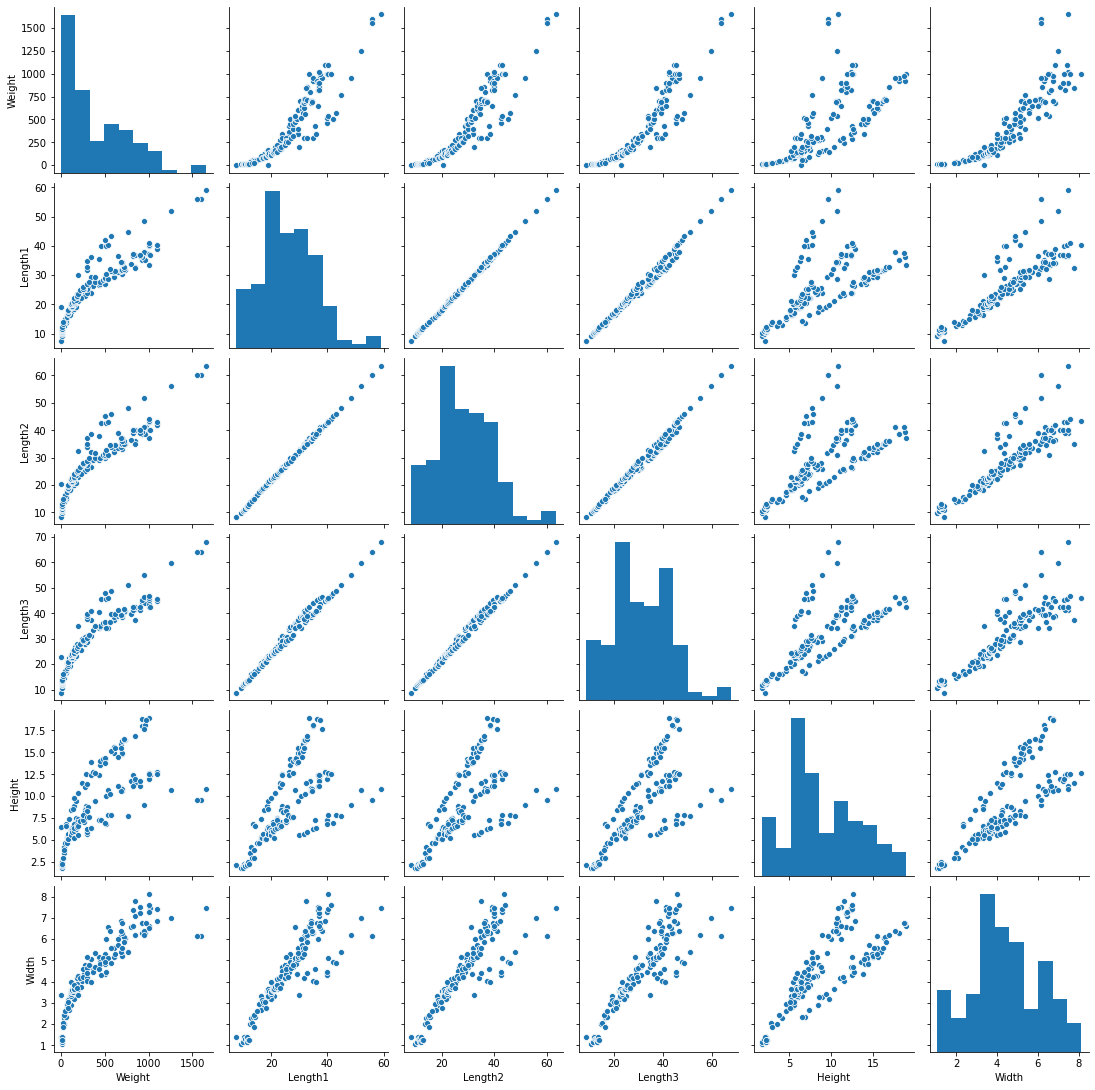

In [123]:
sbn.pairplot(fish_df)

<AxesSubplot:>

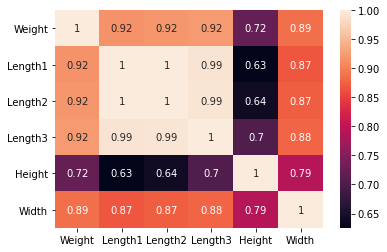

In [124]:
sbn.heatmap(fish_df.corr(), annot=True, fmt='.2g')

#### Almost all features are correlated :( <br> But lets try!

<AxesSubplot:>

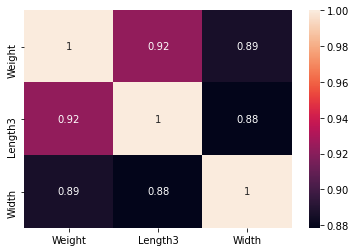

In [213]:
fish_feature = fish_df.drop(columns=['Length1', 'Length2', 'Species', 'Height'])
#fish_feature = fish_df[['Weight', 'Length1']]
#print(fish_feature)
sbn.heatmap(fish_feature.corr(), annot=True, fmt='.2g')

In [214]:
fish_target = fish_df['Height']

In [215]:
X_train, X_test, Y_train, Y_test = train_test_split(fish_feature, fish_target, test_size=0.3)
reg = Ridge(alpha=2)
reg.fit(X_train, Y_train)

Ridge(alpha=2)

In [216]:
print('Weights vector:', reg.coef_)
Y_pred = reg.predict(X_test)
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))
print('\n\n Comparing of predicted and test targets:')
print(pd.concat([Y_test.reset_index(), pd.Series(Y_pred, name='pred').reset_index()], axis=1))

Weights vector: [ 1.56762435e-03 -4.52340638e-02  1.82043402e+00]
Mean squared error: 8.83


 Comparing of predicted and test targets:
    index   Height  index       pred
0       7  12.6700      0   9.114031
1      34  17.6235      1  12.530949
2      70  11.0880      2   8.253301
3      31  18.0840      3  12.508968
4      42   6.1146      4   6.661138
5      80   5.1376      5   6.268688
6      10  14.2628      6   9.947022
7      96   7.2930      7   7.524737
8      87   5.6400      8   7.090159
9      95   6.2750      9   7.464776
10     84   5.6925     10   7.402643
11     15  15.4380     11  10.963904
12    158   2.9322     12   4.267378
13    154   2.0904     13   3.497960
14     77   5.2224     14   6.883037
15     28  16.8896     15  12.282536
16     24  16.2405     16  10.987778
17    143   9.6000     17  12.267599
18     90   5.5225     18   7.930087
19    156   2.2770     19   3.229010
20     32  18.7542     20  13.236347
21     51   7.0866     21   7.678772
22    112  10.

#### Lets try LR without regularization:

In [217]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
print('Weights vector:', linreg.coef_)
Y_pred = linreg.predict(X_test)
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))

Weights vector: [ 1.40083459e-03 -4.84269677e-02  1.88382565e+00]
Mean squared error: 8.84


#### Lets try MAE LR:

In [240]:
mae = MaeLinearRegression(1e-7, 1, 100000)
mae.fit(X_train.to_numpy(), np.array([Y_train]).T)
print('Weights vector:', mae.coef_)
Y_pred = mae.predict(X_test)
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))
print('\n\n Comparing of predicted and test targets:')
print(np.concatenate([Y_pred.to_numpy(), np.array([Y_test]).T], axis=1))

Exit with reaching n_iters
Weights vector: [[3.48000000e-05 1.02130140e-01 1.09908863e+00]]
Mean squared error: 10.53


 Comparing of predicted and test targets:
[[ 8.74285257 12.67      ]
 [11.78385562 17.6235    ]
 [ 7.4237676  11.088     ]
 [11.44242582 18.084     ]
 [ 6.04538799  6.1146    ]
 [ 5.46497726  5.1376    ]
 [ 9.32360925 14.2628    ]
 [ 6.70405554  7.293     ]
 [ 6.27852171  5.64      ]
 [ 6.65327464  6.275     ]
 [ 6.3331857   5.6925    ]
 [ 9.95303576 15.438     ]
 [ 3.72060814  2.9322    ]
 [ 2.90065835  2.0904    ]
 [ 5.61511148  5.2224    ]
 [11.09078478 16.8896    ]
 [10.30343702 16.2405    ]
 [13.3430695   9.6       ]
 [ 6.79474536  5.5225    ]
 [ 2.79005599  2.277     ]
 [12.07720386 18.7542    ]
 [ 7.14873509  7.0866    ]
 [11.55105781 10.881     ]
 [ 2.44714661  1.7284    ]
 [ 6.76120568  6.4395    ]
 [ 6.27904371  5.875     ]
 [ 9.92988506 15.9936    ]
 [11.34468099 10.6091    ]
 [ 9.13010978 12.444     ]
 [11.4671378  18.0369    ]
 [ 8.34950947 12.3778    ]
 